<a href="https://colab.research.google.com/github/caio-valente/TriboBR2023_Image-processing/blob/main/Image_Processing_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import numpy as np  # math
import pandas as pd  # handling datasets
import plotly.express as px  # plotting interactive graphs
import plotly.graph_objects as go  # plotting advanced interactive graphs
from PIL import Image  # image displaying with plotly
from cv2 import imread, imwrite  # Open Source Computer Vision
from pathlib import Path  # file path handling
from os import listdir
from os.path import isfile, join

In [2]:
p = Path('src')  # path to images and manual measurements

In [12]:
#list all files in src directory

filenames = [f for f in listdir(p) if isfile(join(p, f))]
imgs = dict()

#open images and save to a dictionary (key = filename)
for filename in filenames:
    if filename != 'wear_widths_manual.xlsx':
      filepath = p/filename
      try:
          imgs[filepath.name] = imread(str(filepath))
      except FileNotFoundError:
          pass

In [61]:
#each image is a matrix of 3-dimensional vectors representing blue, green and red colors
imgs[list(imgs.keys())[0]]

array([[[  0,   0, 154],
        [  0,   0, 149],
        [  1,   0, 138],
        ...,
        [ 53,  31,  20],
        [ 55,  29,  22],
        [ 56,  27,  22]],

       [[ 10,  26,  63],
        [ 10,  23,  55],
        [ 16,  22,  45],
        ...,
        [ 57,  28,  23],
        [ 59,  25,  25],
        [ 60,  23,  25]],

       [[ 35,  23,  53],
        [ 33,  19,  43],
        [ 37,  17,  30],
        ...,
        [ 64,  25,  27],
        [ 64,  21,  30],
        [ 65,  19,  31]],

       ...,

       [[ 71,  17,  22],
        [ 71,  21,  25],
        [ 62,  24,  24],
        ...,
        [ 66,  16,  20],
        [ 54,  23,  22],
        [ 52,  27,  23]],

       [[ 80,  28,  35],
        [ 80,  32,  38],
        [ 69,  33,  33],
        ...,
        [ 74,  12,  30],
        [ 60,  15,  31],
        [ 57,  18,  33]],

       [[ 91,  38,  47],
        [ 89,  41,  47],
        [ 79,  45,  45],
        ...,
        [ 80,   9,  35],
        [ 66,  11,  36],
        [ 63,  15,  39]]

In [14]:
dfs = dict()
left_edge_px = dict()
right_edge_px = dict()
high = dict()
low = dict()
width = dict()

for key, img in imgs.items():
    dfs[key] = pd.DataFrame({
        'Blue': imgs[key][:,:,0].sum(axis = 0),
        'Red': imgs[key][:,:,2].sum(axis = 0),
        'Green': imgs[key][:,:,1].sum(axis = 0)
    })
    high[key] = max(dfs[key]['Blue'])  # using blue channel as it's the highest intensity
    low[key] = min(dfs[key]['Blue'])
    
#calculates mean width based on threshold, where threshold=1.0 means the threshold is exactly the average intensity in the image
def calculate(threshold=1.0):
    for key in list(imgs.keys()):
        df = dfs[key].reset_index()
        intensity_mean = np.mean((high[key],low[key]))
        interest_points = (df['index'] < 1500) & (df['Blue'] >= float(threshold) * intensity_mean)
        left_edge_px[key] = df[interest_points].index.min()
        right_edge_px[key] = df[interest_points].index.max()
        width[key] = 1.262626 * (right_edge_px[key] - left_edge_px[key])

In [17]:
width_measured = pd.read_excel('src/wear_widths_manual.xlsx')
columns = ['Largura 1','Largura 2','Largura 3']
width_measured['width'] = width_measured[columns].fillna(0).apply(np.mean, axis = 'columns')

std_dev = []
for threshold in np.linspace(0.1,1.0,100):  # brute force from 0.1 to 1.0 thresholds
    calculate(threshold)
    std_error = 0
    n = 0
    error = dict()
    for key, value in width.items():
        mask = width_measured['Foto'] == key[:-4]
        error[key] = value - float(width_measured.loc[mask, 'width'])
        std_error += error[key] ** 2
        n += 1
    std_dev.append((np.sqrt(std_error / (n - 1)), threshold))
min(std_dev) #show minimum error and respective threshold

(11.601788739304787, 0.8727272727272727)

In [62]:
# Plots color intensity by channel along the image
def plot_colors(key):
    fig = px.line(dfs[key])
    fig.update_yaxes(title = "Total Intensity").update_xaxes(title = "Pixel").update_layout(margin={"l": 0, "r": 0, "t": 0, "b": 0}, width=1200,height=400, legend_title="Color").show()

In [64]:
# Plots image and detected wear track edges
def plot_overlay(key):
    path = p/key
    fig = go.Figure()
    img_width = 2048
    img_height = 1532
    scale_factor = 0.58
    # Adds invisible trace to handle image
    fig.add_trace(
        go.Scatter(
            x=[0, img_width * scale_factor],
            y=[0, img_height * scale_factor],
            mode="markers",
            marker_opacity=0
        )
    )
    # Axis configuration
    fig.update_xaxes(
        visible=False,
        range=[0, img_width * scale_factor]
    )
    fig.update_yaxes(
        visible=False,
        range=[0, img_height * scale_factor],
        # force constant aspect ratio
        scaleanchor="x"
    )
    # add background image
    fig.add_layout_image(
        dict(
            x=0,
            sizex=img_width * scale_factor,
            y=img_height * scale_factor,
            sizey=img_height * scale_factor,
            xref="x",
            yref="y",
            opacity=1.0,
            layer="below",
            sizing="stretch",
            source=Image.open('src/{}'.format(key)))
    )
    # add lines indicating wear track edges
    fig.add_vline(x = scale_factor*left_edge_px[key], line_color = 'red')
    fig.add_vline(x = scale_factor*right_edge_px[key], line_color = 'red')
    # other layout configurations
    fig.update_layout(
        width=img_width * scale_factor,
        height=img_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
    fig.show(config={'doubleClick': 'reset'})

In [70]:
list(imgs.keys())
PU+4EG_50x_7_b

['PU+4EG_50x_14_c.jpg',
 'PU+4EG_50x_1_a.jpg',
 'PU+4EG_50x_1_c.jpg',
 'PU+4EG_50x_13_b.jpg',
 'PU+4EG_50x_4_a.jpg',
 'PU+1GE-6-c.jpg',
 'PU+4EG_50x_13_c.jpg',
 'PU+2GE-11-a.jpg',
 'PU+4EG_50x_3_b.jpg',
 'PU+1GE-11-b.jpg',
 'PU+2GE-10-b.jpg',
 'PU+1GE-8-a.jpg',
 'PU+1GE-8-c.jpg',
 'PU+1GE-7-c.jpg',
 'PU+1GE-8-b.jpg',
 'PU+2GE-8-a.jpg',
 'PU+1GE-6-b.jpg',
 'PU+4EG_50x_13_a.jpg',
 'PU+4EG_50x_14_b.jpg',
 'PU+4EG_50x_7_a.jpg',
 'PU+2GE-9-b.jpg',
 'PU+4EG_50x_7_b.jpg',
 'PU+2GE-8-c.jpg',
 'PU+2GE-9-a.jpg',
 'PU+1GE-11-c.jpg',
 'PU+1GE-12-a.jpg',
 'PU+4EG_50x_3_c.jpg',
 'PU+2GE-12-a.jpg',
 'PU+2GE-11-b.jpg',
 'PU+4EG_50x_7_c.jpg',
 'PU+1GE-12-b.jpg',
 'PU+4EG_50x_14_a.jpg',
 'PU+2GE-10-c.jpg',
 'PU+2GE-7-c.jpg',
 'PU+4EG_50x_1_b.jpg',
 'PU+1GE-7-b.jpg',
 'PU+2GE-8-b.jpg',
 'PU+1GE-12-c.jpg',
 'PU+2GE-7-a.jpg',
 'PU+1GE-7-a.jpg',
 'PU+4EG_50x_4_c.jpg',
 'PU+4EG_50x_3_a.jpg',
 'PU+2GE-10-a.jpg',
 'PU+2GE-11-c.jpg',
 'PU+2GE-9-c.jpg',
 'PU+1GE-11-a.jpg',
 'PU+2GE-7-b.jpg',
 'PU+4EG_50x_4_b.jpg

In [71]:
#@title Select image index
index = 21 #@param {type:"integer"}


In [72]:
plot_colors(list(imgs.keys())[index])


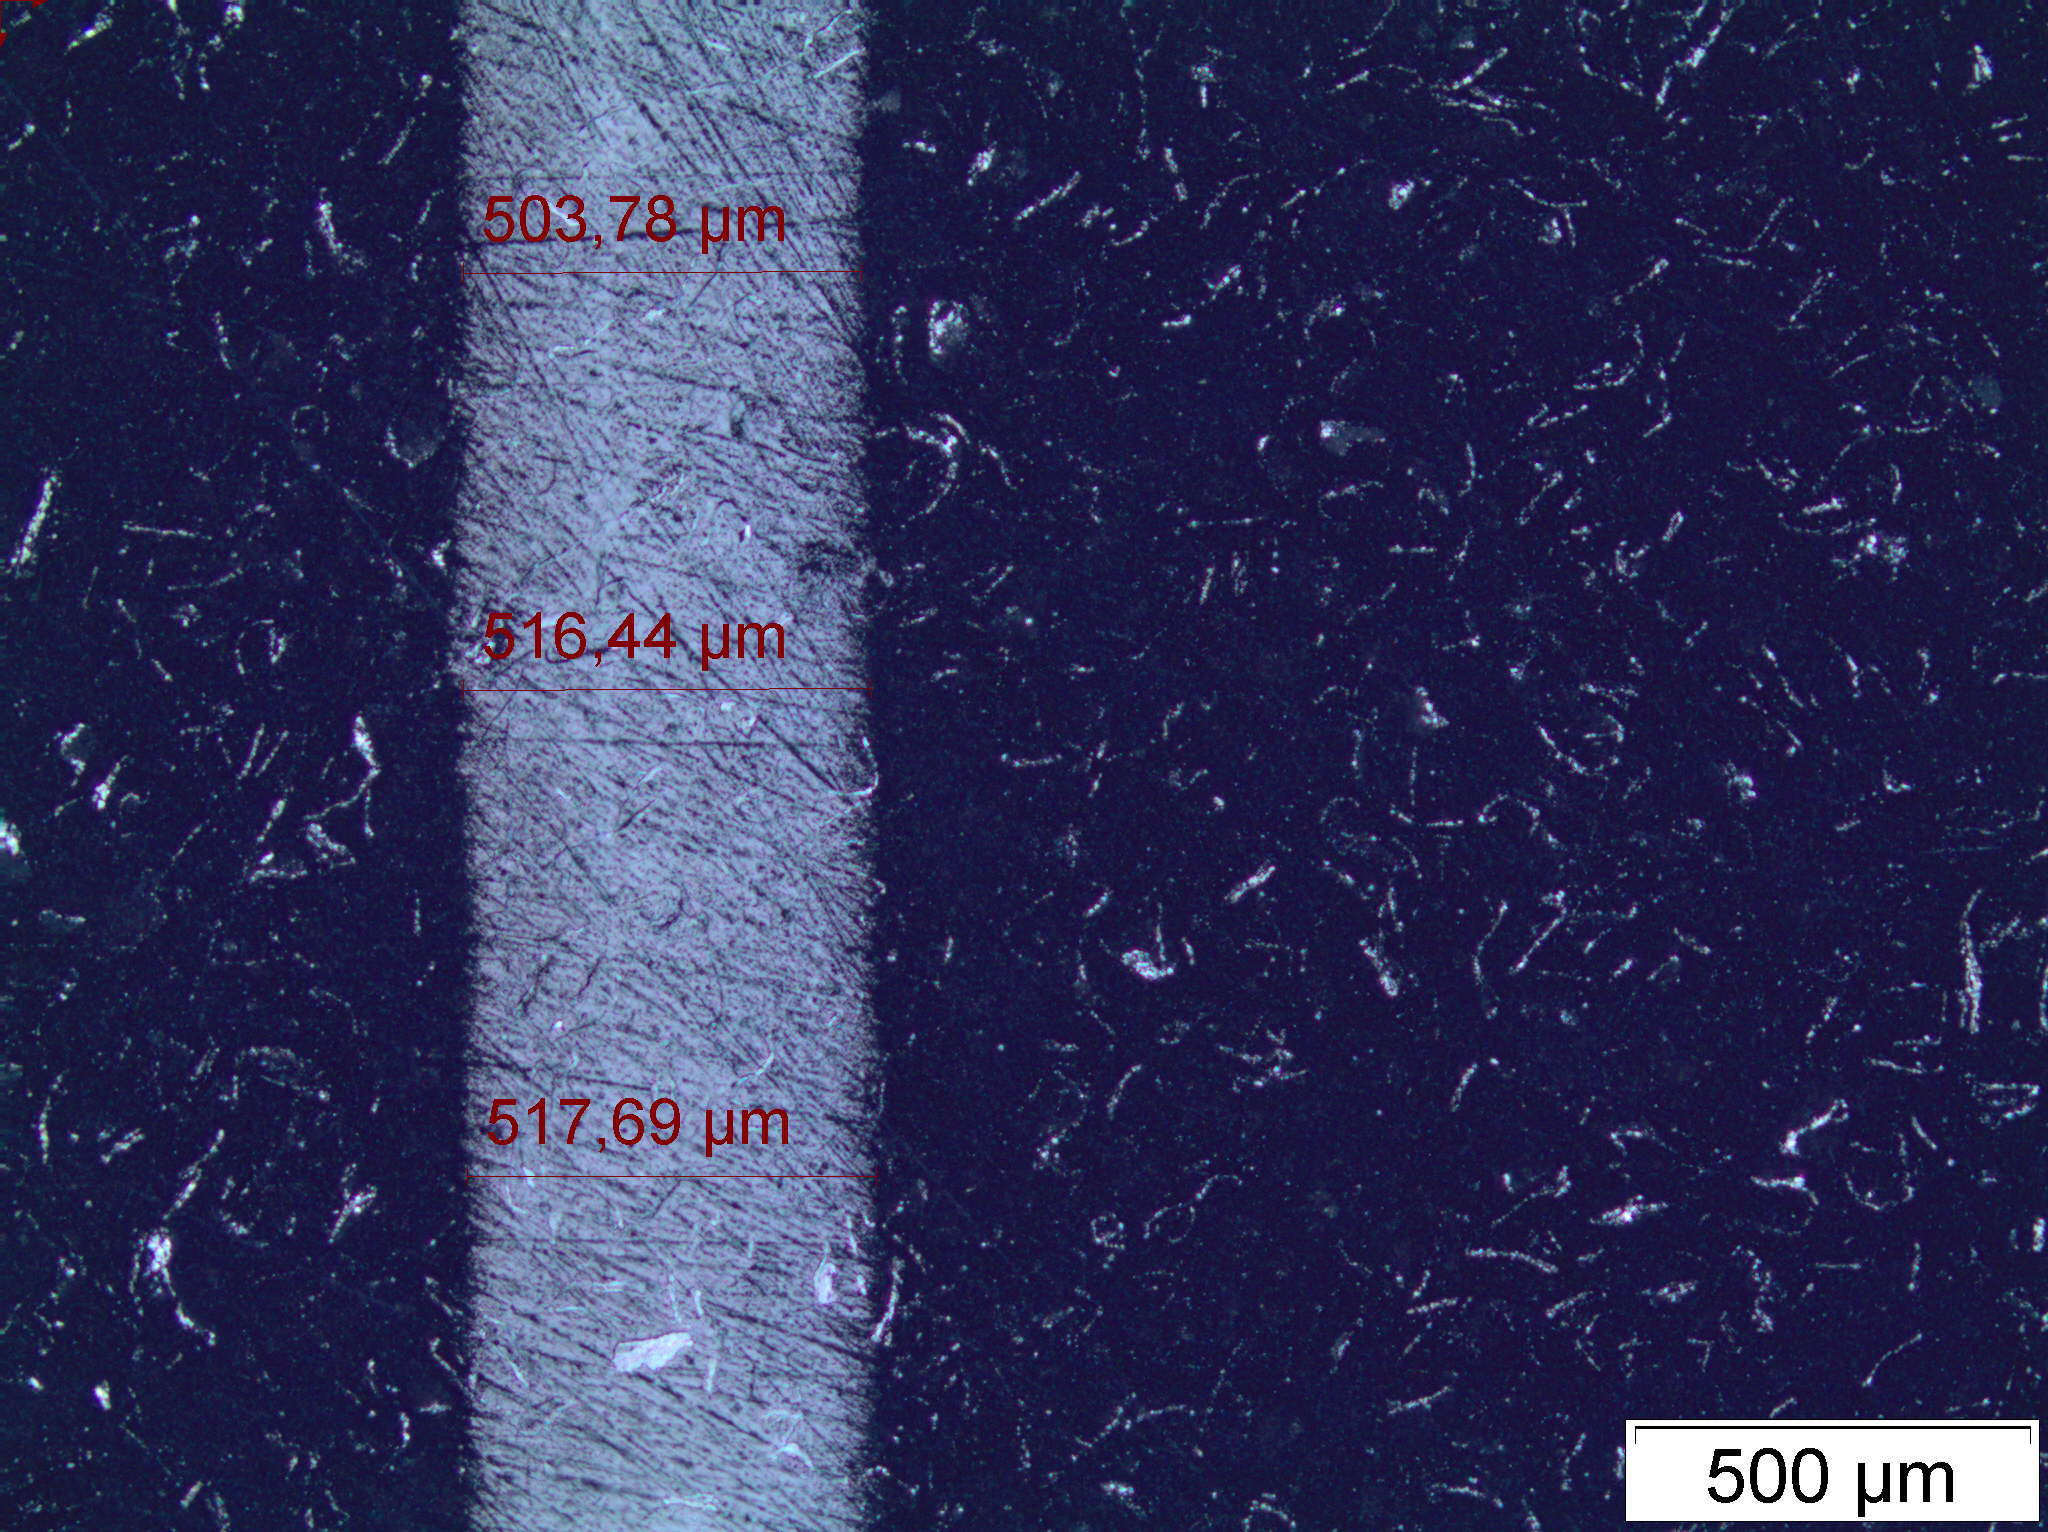

In [73]:
plot_overlay(list(imgs.keys())[index])

In [ ]:
width

{'PU+1GE-11-a.jpg': 251.262574,
 'PU+1GE-11-b.jpg': 234.848436,
 'PU+1GE-11-c.jpg': 233.58581,
 'PU+1GE-12-a.jpg': 396.464564,
 'PU+1GE-12-b.jpg': 382.575678,
 'PU+1GE-12-c.jpg': 415.403954,
 'PU+1GE-6-b.jpg': 424.242336,
 'PU+1GE-6-c.jpg': 436.868596,
 'PU+1GE-7-a.jpg': 424.242336,
 'PU+1GE-7-b.jpg': 404.04032,
 'PU+1GE-7-c.jpg': 425.50496200000003,
 'PU+1GE-8-a.jpg': 325.75750800000003,
 'PU+1GE-8-b.jpg': 325.75750800000003,
 'PU+1GE-8-c.jpg': 338.38376800000003,
 'PU+2GE-10-a.jpg': 266.414086,
 'PU+2GE-10-b.jpg': 258.83833,
 'PU+2GE-10-c.jpg': 262.626208,
 'PU+2GE-11-a.jpg': 361.111036,
 'PU+2GE-11-b.jpg': 358.585784,
 'PU+2GE-11-c.jpg': 354.797906,
 'PU+2GE-12-a.jpg': 457.070612,
 'PU+2GE-7-a.jpg': 340.90902,
 'PU+2GE-7-b.jpg': 333.333264,
 'PU+2GE-7-c.jpg': 338.38376800000003,
 'PU+2GE-8-a.jpg': 429.29284,
 'PU+2GE-8-b.jpg': 412.87870200000003,
 'PU+2GE-8-c.jpg': 430.555466,
 'PU+2GE-9-a.jpg': 299.242362,
 'PU+2GE-9-b.jpg': 281.565598,
 'PU+2GE-9-c.jpg': 281.565598,
 'PU+4EG_50x_1

In [ ]:
width_measured

Foto  PU  EG Posição  Ensaio  Largura 1  Largura 2  Largura 3  \
0      PU+1GE-1-a  99   1    Meio       1     397.46     394.95     396.21   
1      PU+1GE-1-b  99   1   Ponta       1     408.87     439.23        NaN   
2      PU+1GE-1-c  99   1   Ponta       1     426.56     406.31        NaN   
3      PU+1GE-2-a  99   1   Ponta       2     338.00     327.84     312.68   
4      PU+1GE-2-b  99   1    Meio       2     302.53     315.27     315.34   
..            ...  ..  ..     ...     ...        ...        ...        ...   
145  PU+C_2GE-3-b  98   2    Meio      15     367.08     362.02     367.08   
146  PU+C_2GE-3-c  98   2   Ponta      15     362.01     362.02     369.60   
147  PU+C_2GE-4-a  98   2   Ponta      16     353.15     351.89     355.68   
148  PU+C_2GE-4-b  98   2    Meio      16     346.82     354.42     349.36   
149  PU+C_2GE-4-c  98   2   Ponta      16     349.36     351.88     364.54   

     Força Normal  Frequência       width  
0            8.00           4  396.206667  
1            8.00           4  282.700000  
2            8.00           4  277.623333  
3            5.00           2  326.173333  
4            5.00           2  311.046667  
..            ...         ...         ...  
145          5.17           3  365.393333  
146          5.17           3  364.543333  
147          5.17           3  353.573333  
148          5.17           3  350.200000  
149          5.17           3  355.260000  

[150 rows x 11 columns]

In [ ]:
error

{'PU+1GE-11-a.jpg': -36.654092666666685,
 'PU+1GE-11-b.jpg': -33.98489733333338,
 'PU+1GE-11-c.jpg': -34.41085666666666,
 'PU+1GE-12-a.jpg': -36.61543599999999,
 'PU+1GE-12-b.jpg': -36.127655333333394,
 'PU+1GE-12-c.jpg': -2.0193793333333474,
 'PU+1GE-6-b.jpg': -21.02766399999996,
 'PU+1GE-6-c.jpg': -22.201403999999968,
 'PU+1GE-7-a.jpg': -21.09099733333329,
 'PU+1GE-7-b.jpg': -24.753013333333342,
 'PU+1GE-7-c.jpg': -21.988371333333305,
 'PU+1GE-8-a.jpg': -19.525825333333273,
 'PU+1GE-8-b.jpg': -15.669158666666647,
 'PU+1GE-8-c.jpg': -20.00956533333334,
 'PU+2GE-10-a.jpg': -12.632580666666684,
 'PU+2GE-10-b.jpg': -16.01833666666664,
 'PU+2GE-10-c.jpg': -31.180458666666652,
 'PU+2GE-11-a.jpg': -16.255630666666605,
 'PU+2GE-11-b.jpg': -11.770882666666637,
 'PU+2GE-11-c.jpg': -22.26542733333332,
 'PU+2GE-12-a.jpg': -13.409388000000035,
 'PU+2GE-7-a.jpg': -31.974313333333384,
 'PU+2GE-7-b.jpg': -27.75006933333333,
 'PU+2GE-7-c.jpg': -27.75623200000001,
 'PU+2GE-8-a.jpg': -25.86382666666657